# Analyzing and tuning a transmon qubit with a resonator
We will showcase two methods (EPR amd LOM) to analyze the same design. Specifically, we will use here the `advanced` methods to run the simulations and analysis, which directly contorl renderers and external packages. Please refer to the tutorial notebooks 4.1 and 4.2 to follow the `suggested` flow to run the analysis.

## Index
#### Transmon & resonator design
1. Prepare the single transmon qubit layout in qiskit-metal. <br>

#### Transmon & resonator analysis using EPR method
1. Set-up and run a finite element simulate to extract the eigenmode. <br>
1. Display EM fields to inspect quality of the setup. <br>
1. Identify junction parameters for the EPR analysis. <br>
1. Run EPR analysis on single eigenmode. <br>
1. Get qubit freq and anharmonicity. <br>
1. Calculate EPR of substrate.  <br>

#### Transmon & resonator analysis using LOM method
1. Calculate the capacitance matrix. <br>
1. Execute analysis on extracted LOM. <br>

## Prerequisite
You need to have a working local installation of Ansys.<br>
Also you will need the following directives and inports.

In [1]:
%load_ext autoreload
%autoreload 2

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
import pyEPR as epr

# 1. Create the Qbit design

Fix the design dimensions that you intend to reflect in the design rendering. <br>
Note that the design size extends from the origin into the first quadrant.

In [2]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '2mm'
design.chips.main.size['size_y'] = '2mm'

gui = MetalGUI(design)

Create a single transmon with one readout resonator. Please refer to the notebook tutorials 4.11 ad 4.12 if you're not familiar with the code in the cell below.

In [3]:
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander

design.delete_all_components()

q1 = TransmonPocket(design, 'Q1', options = dict(
    pad_width = '425 um', 
    pocket_height = '650um',
    connection_pads=dict(
        readout = dict(loc_W=+1,loc_H=+1, pad_width='200um')
    )))
otg = OpenToGround(design, 'open_to_ground', options=dict(pos_x='1.75mm',  pos_y='0um', orientation='0'))
readout = RouteMeander(design, 'readout',  Dict(
            total_length='6 mm',
            hfss_wire_bonds = True,
            fillet='90 um',
            lead = dict(start_straight='100um'),
            pin_inputs=Dict(
                start_pin=Dict(component='Q1', pin='readout'),
                end_pin=Dict(component='open_to_ground', pin='open')), ))

gui.rebuild()
gui.autoscale()

# 2. Analyze the transmon & resonator using the Eigenmode-EPR method

In this section we will use a semi-manual (advanced) analysis flow. Please refer to tutorial 4.2 for the `suggested` method. As illustrated, the methods are equivalent, but the advanced method allows you to directly override some renderer-specific settings.

### Finite Element Eigenmode Analysis

#### Setup

Select the analysis you intend to run from the `qiskit_metal.analyses` collection.<br>
Select the design to analyze and the tool to use for any external simulation.

In [4]:
from qiskit_metal.analyses.quantization import EPRanalysis
eig_qres = EPRanalysis(design, "hfss")

For the Eigenmode simulation portion, you can either:
1. Use the `eig_qres` user-friendly methods (see tutorial 4.2)
2. Control directly the simulation tool from the tool's GUI (outside metal - see specific vendor instructions)
3. Use the renderer methods
In this section we show the advanced method (method 3).

The renderer can be reached from the analysis class. Let's give it a shorter alias.

In [5]:
hfss = eig_qres.renderer

Now we connect to the tool using the unified command.

In [6]:
hfss.start()

INFO 03:32PM [connect_project]: Connecting to Ansys Desktop API...
INFO 03:32PM [load_ansys_project]: 	Opened Ansys App
INFO 03:32PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 03:32PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project20
INFO 03:32PM [connect_design]: No active design found (or error getting active design).
INFO 03:32PM [connect]: 	 Connected to project "Project20". No design detected


True

The previous command is supposed to open ansys (if closed), create a new project and finally connect this notebook to it.

If for any reason the previous cell failed, please try the manual path described in the next three cells:
1. uncomment and execute only **one** of the lines in the first cell.
1. uncomment and execute the second cell.
1. uncomment and execute only **one** of the lines in the third cell.

In [ ]:
# hfss.open_ansys()   # this opens Ansys 2021 R2 if present
# hfss.open_ansys(path_var='ANSYSEM_ROOT211')
# hfss.open_ansys(path='C:\Program Files\AnsysEM\AnsysEM21.1\Win64')
# hfss.open_ansys(path='../../../Program Files/AnsysEM/AnsysEM21.1/Win64')

In [ ]:
# hfss.new_ansys_project()

In [ ]:
# hfss.connect_ansys()
# hfss.connect_ansys('C:\\project_path\\', 'Project1')  # will open a saved project before linking the Jupyter session

#### Execute simulation and verify convergence

Create and activate an eigenmode design called "TransmonReadout".

In [7]:
hfss.activate_ansys_design("TransmonReadout", 'eigenmode')  # use new_ansys_design() to force creation of a blank design

03:32PM 44s WARNING [activate_ansys_design]: The design_name=TransmonReadout was not in active project.  Designs in active project are: 
[].  A new design will be added to the project.  
INFO 03:32PM [connect_design]: 	Opened active design
	Design:    TransmonReadout [Solution type: Eigenmode]
WARNING 03:32PM [connect_setup]: 	No design setup detected.
WARNING 03:32PM [connect_setup]: 	Creating eigenmode default setup.
INFO 03:32PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


Render everything inlcuding the qubit and resonator in Metal, to "TransmonReadout" design in Ansys.

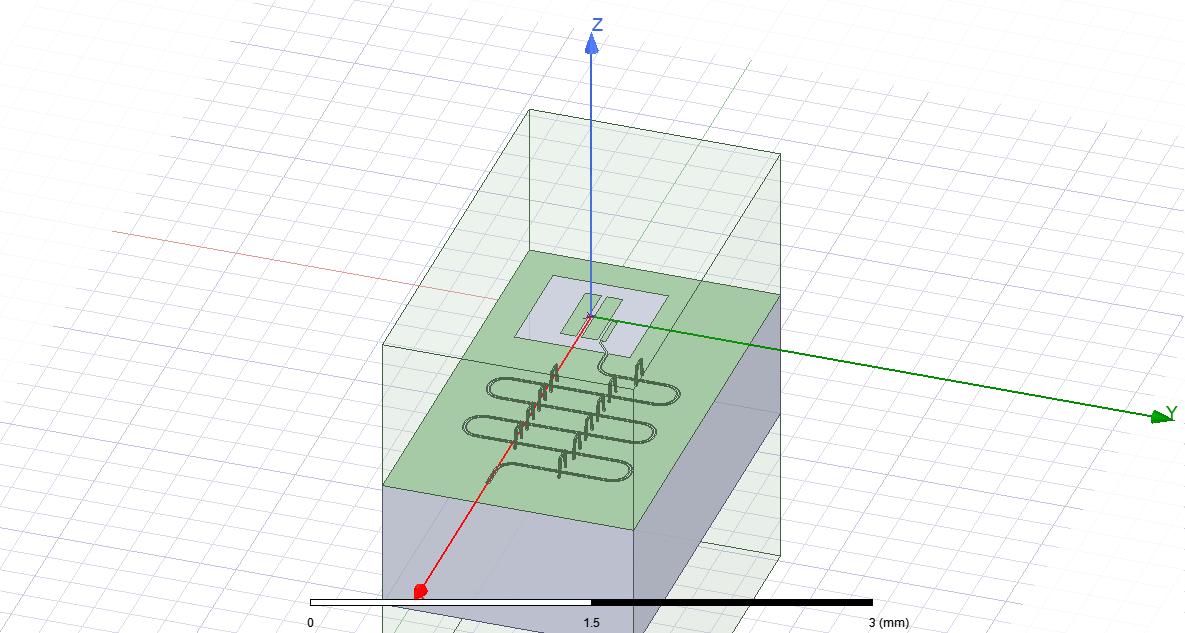

WindowsPath('C:/workspace/qiskit-metal/docs/tut/4-Analysis/ansys.png')

In [8]:
hfss.render_design(['Q1', 'readout', 'open_to_ground'], [])
hfss.save_screenshot()

Set the convergence parameters and junction properties in the Ansys design. <br>
Then run the analysis and plot the convergence.

Note that we seek 2 eigenmodes - one with stronger fields near the transmon, the other with stronger fields near the resonator.

In [9]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes = 2
setup.passes = 10
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '10 nH')
pinfo.design.set_variable('Cj', '0 fF')

setup.analyze()

INFO 03:32PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 2
Number of simulation passes              = 10
Convergence freq max delta percent diff  = 0.1



To plot the results you can use the `plot_convergences()` method from the `QAnalysis` class. The class method will read the data from the variables local to the `eig_qres` object, so we first need to assign the simulation results to these two variables. let's do both (assignment and plotting) in the next cell.

In [10]:
eig_qres.convergence_t, eig_qres.convergence_f, _ = hfss.get_convergences()
eig_qres.plot_convergences()

03:34PM 16s INFO [get_f_convergence]: Saved convergences to C:\workspace\qiskit-metal\docs\tut\4-Analysis\hfss_eig_f_convergence.csv


#### Plot the EM field for inspection
Display the Ansys modeler window and plot the E-field on the chip's surface.

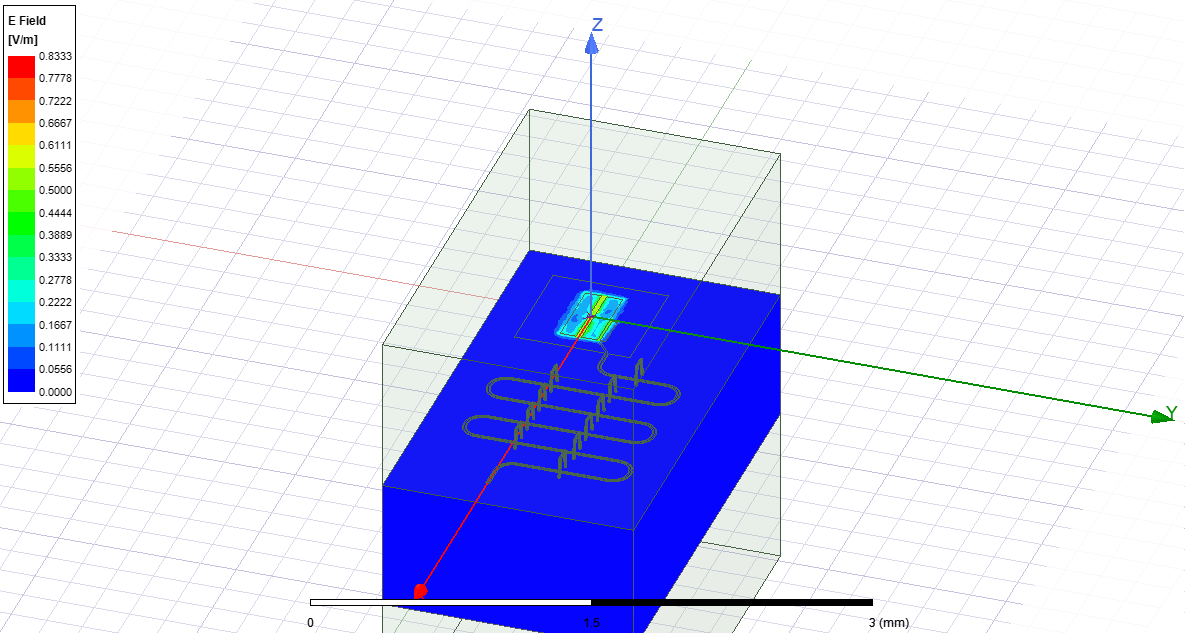

In [11]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_fields('main')
hfss.save_screenshot()

Delete the newly created E-field plot before moving on.

In [12]:
hfss.clear_fields(['Mag_E1'])

To look at the second eigenmode created, we use the following command, and then plot the corresponding E-field.

In [13]:
hfss.set_mode(2, "Setup")

INFO 03:34PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


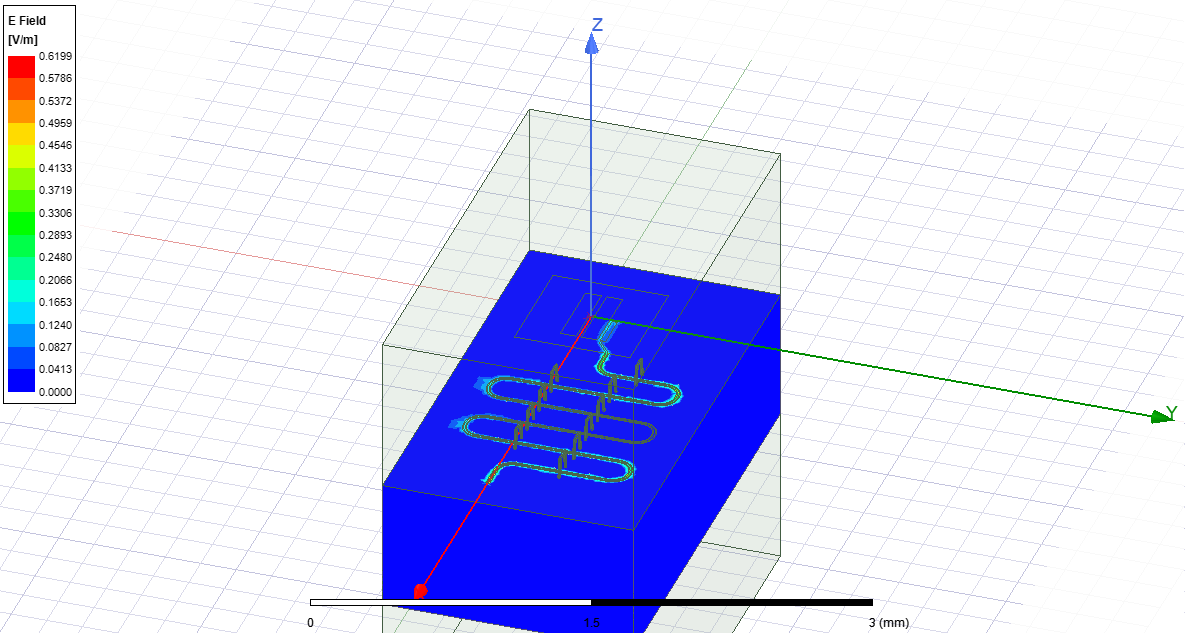

WindowsPath('C:/workspace/qiskit-metal/docs/tut/4-Analysis/ansys.png')

In [14]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_fields('main')
hfss.save_screenshot()

We delete this design to prepare for further analysis.

In [15]:
hfss.clear_fields(['Mag_E1'])

### EPR Analysis
In the `suggested` (tutorial 4.2) flow, we would now prepare the setup using `eig_qres.setup.epr` and run the analysis with `eig_qres.run_epr()`. Notice that this method requires previous set of the `eig_qres` variables `convergence_t` and `convergence_f` like we did a thee cells earlier.

However we here exemplify the advanced approach, which is Ansys-specific since it uses the pyEPR module methods directly.
#### Setup
Identify the non-linear (Josephson) junctions in the model. You will need to list the junctions in the epr setup.

In this case there's only one junction, namely 'jj'. Let's see what we need to change in the default setup.

In [16]:
pinfo = hfss.pinfo
pinfo.junctions['jj'] = {'Lj_variable': 'Lj', 'rect': 'JJ_rect_Lj_Q1_rect_jj', 
                             'line': 'JJ_Lj_Q1_rect_jj_',  'Cj_variable': 'Cj'}
pinfo.validate_junction_info() # Check that valid names of variables and objects have been supplied
pinfo.dissipative['dielectrics_bulk'] = ['main'] # Dissipative elements: specify

#### Execute the energy distribution analysis

Execute microwave analysis on eigenmode solutions.

In [17]:
eprd = epr.DistributedAnalysis(pinfo)

Design "TransmonReadout" info:
	# eigenmodes    2
	# variations    1


Find the electric and magnetic energy stored in the substrate and the system as a whole.

In [18]:
ℰ_elec = eprd.calc_energy_electric()
ℰ_elec_substrate = eprd.calc_energy_electric(None, 'main')
ℰ_mag = eprd.calc_energy_magnetic()

print(f"""
ℰ_elec_all       = {ℰ_elec}
ℰ_elec_substrate = {ℰ_elec_substrate}
EPR of substrate = {ℰ_elec_substrate / ℰ_elec * 100 :.1f}%

ℰ_mag_all       = {ℰ_mag}
ℰ_mag % of ℰ_elec_all  = {ℰ_mag / ℰ_elec * 100 :.1f}%
""")


ℰ_elec_all       = 4.41106851275954e-24
ℰ_elec_substrate = 4.01957775292846e-24
EPR of substrate = 91.1%

ℰ_mag_all       = 4.4047058297158e-24
ℰ_mag % of ℰ_elec_all  = 99.9%



#### Run EPR analysis

Perform EPR analysis for all modes and variations.

In [19]:
eprd.do_EPR_analysis()

# 4a. Perform Hamiltonian spectrum post-analysis, building on mw solutions using EPR
epra = epr.QuantumAnalysis(eprd.data_filename)
epra.analyze_all_variations(cos_trunc = 8, fock_trunc = 7)

# 4b. Report solved results
swp_variable = 'Lj' # suppose we swept an optimetric analysis vs. inductance Lj_alice
epra.plot_hamiltonian_results(swp_variable=swp_variable)
epra.report_results(swp_variable=swp_variable, numeric=True)


Variation 0  [1/1]

  Mode 0 at 6.14 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.2%  8.959e-24 7.242e-26

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 97.11%
	jj              0.990594  (+)        0.0294592
		(U_tot_cap-U_tot_ind)/mean=1.52%
Calculating Qdielectric_main for mode 0 (0/1)
p_dielectric_main_0 = 0.9153974977946466

  Mode 1 at 9.32 GHz   [2/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
                0.1%  2.206e-24 2.202e-24

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_1j   sign s_1j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 93.59%
	jj              0.00288093  (+)        0.000197446
		(U_tot_cap-U_tot_ind)/mean=-0.06%
Calculating Qdielectri

WARNING 03:34PM [__init__]: <p>Error: <class 'IndexError'></p>



ANALYSIS DONE. Data saved to:

C:\data-pyEPR\Project20\TransmonReadout\2021-07-08 15-34-23.npz


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

Starting the diagonalization
Finished the diagonalization
Pm_norm=
modes
0    1.030949
1    0.784123
dtype: float64

Pm_norm idx =
      jj
0   True
1  False
*** P (participation matrix, not normlz.)
         jj
0  0.962247
1  0.002880

*** S (sign-bit matrix)
   s_jj
0     1
1     1
*** P (participation matrix, normalized.)
      0.99
    0.0029

*** Chi matrix O1 PT (MHz)
    Diag is anharmonicity, off diag is full cross-Kerr.
       283      2.5
       2.5  0.00551

*** Chi matrix ND (MHz) 
       315     2.15
      2.15  0.00409

*** Frequencies O1 PT (MHz)
0    5852.466824
1    9315.456443
dtype: float64

*** Frequencies ND (MHz)
0    5837.569720
1    9315.502095
dtype: float64

*** Q_coupling
Empty DataFrame
Columns: []
Index: [0, 1]


#### Mode frequencies (MHz)

###### Numerical diagonalization

Lj,10
eigenmode,
0,5852.47
1,9315.46


#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0         1
Lj                    
10 0  315.13  2.15e+00
   1    2.15  4.09e-03

Release Ansys session

In [20]:
eig_qres.close()

# 3. Analyze the transmon using the LOM method

In this section we will use a semi-manual (advanced) analysis flow. Please refer to tutorial 4.1 for the `suggested` method. As illustrated, the methods are equivalent, but the advanced method allows you to directly override some renderer-specific settings.

### Capacitance matrix extraction
#### Setup
Select the analysis you intend to run from the `qiskit_metal.analyses` collection.<br>
Select the design to analyze and the tool to use for any external simulation.

In [21]:
from qiskit_metal.analyses.quantization import LOManalysis
c2 = LOManalysis(design, "q3d")

For the capacitive simulation portion, you can either:
1. Use the `c2` user-friendly methods (see tutorial 4.1)
2. Control directly the simulation tool from the tool's GUI (outside metal - see specific vendor instructions)
3. Use the renderer methods
In this section we show the advanced method (method 3).

The renderer can be reached from the analysis class. Let's give it a shorter alias.

In [22]:
q3d = c2.renderer

Now we connect to the simulation tool, similarly to what we have done for the eigenmode analysis.

In [23]:
q3d.start()

INFO 03:34PM [connect_project]: Connecting to Ansys Desktop API...
INFO 03:34PM [load_ansys_project]: 	Opened Ansys App
INFO 03:34PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 03:34PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Ansoft/
	Project:   Project20
INFO 03:34PM [connect_design]: 	Opened active design
	Design:    TransmonReadout [Solution type: Eigenmode]
INFO 03:34PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 03:34PM [connect]: 	Connected to project "Project20" and design "TransmonReadout" 😀 



True

If the simulator is already open, the line above will simply connect to the open session, project and design.

#### Execute simulation and verify convergence

Create and activate a q3d design called "TransmonResonator_q3d".

In [24]:
q3d.activate_ansys_design("TransmonResonator_q3d", 'capacitive')

03:34PM 31s WARNING [activate_ansys_design]: The design_name=TransmonResonator_q3d was not in active project.  Designs in active project are: 
['TransmonReadout'].  A new design will be added to the project.  
INFO 03:34PM [connect_design]: 	Opened active design
	Design:    TransmonResonator_q3d [Solution type: Q3D]
WARNING 03:34PM [connect_setup]: 	No design setup detected.
WARNING 03:34PM [connect_setup]: 	Creating Q3D default setup.
INFO 03:34PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)


Next, we render the exisitng design to Ansys Q3D for analysis. To ensure that the readout is insulated from the ground plane, we set the 'readout' pin of Q1 to have an open termination.

In [25]:
q3d.render_design(['Q1'], [('Q1','readout')])

Execute the capacitance extraction and verify converengence. This cell analyzes the default setup.

In [26]:
q3d.analyze_setup("Setup")

INFO 03:34PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 03:34PM [analyze]: Analyzing setup Setup


This simulation had 4 nets, the two charge islands of the floating transmon, the readout coupler, and the ground, resulting in a 4x4 capacitance matrix. Output is of type DataFrame.

In [27]:
c2.capacitance_matrix, c2.units = q3d.get_capacitance_matrix()
c2.capacitance_all_passes, _ = q3d.get_capacitance_all_passes()
c2.capacitance_matrix

INFO 03:35PM [get_matrix]: Exporting matrix data to (C:\Temp\tmp24ldfr0t.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 03:35PM [get_matrix]: Exporting matrix data to (C:\Temp\tmpsb272w0z.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 03:35PM [get_matrix]: Exporting matrix data to (C:\Temp\tmp28tgl8or.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 03:35PM [get_matrix]: Exporting matrix data to (C:\Temp\tmp6bje6i96.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 3, False
INFO 03:35PM [get_matrix]: Exporting matrix data to (C:\Temp\tmphdj_wtvt.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 4, False
INFO 03:35PM [get_matrix]: Exporting matrix data to (C:\Temp\tmpa09vrz23.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie"

,ground_main_plane,pad_bot_Q1,pad_top_Q1,readout_connector_pad_Q1
ground_main_plane,177.78538,-44.74611,-38.34722,-37.03041
pad_bot_Q1,-44.74611,82.84141,-32.48515,-2.30760
pad_top_Q1,-38.34722,-32.48515,93.38943,-19.67329
readout_connector_pad_Q1,-37.03041,-2.30760,-19.67329,60.14998


### LOM Analysis
Now we provide the junction lumped element values, and complete the analysis by plotting the convergence. This is the same steps used in the `suggested` flow from tutorial 4.1.

In [28]:
c2.setup.lom.junctions=Dict(Lj=12.31, Cj=2)
c2.setup.lom.freq_readout = 7.0
c2.setup.lom.freq_bus = []

c2.run_lom()
c2.lumped_oscillator_all

[1, 2] [3]
Predicted Values

Transmon Properties
f_Q 5.492369 [GHz]
EC 320.340887 [MHz]
EJ 13.273404 [GHz]
alpha -374.552102 [MHz]
dispersion 58.767574 [KHz]
Lq 12.305036 [nH]
Cq 60.467548 [fF]
T1 47.110126 [us]

**Coupling Properties**

tCqbus1 -7.535751 [fF]
gbus1_in_MHz -119.111599 [MHz]
χ_bus1 -3.815566 [MHz]
1/T1bus1 3378.359561 [Hz]
T1bus1 47.110126 [us]
Bus-Bus Couplings


,fQ,EC,EJ,alpha,dispersion,gbus,chi_in_MHz,χr MHz,gr MHz
1,5.848645,366.675723,13.273404,-435.120535,183.838223,[-120.91915969031888],[-7.045838787793941],7.045839,120.919160
2,5.800484,360.198673,13.273404,-426.554207,158.894188,[-112.57027192270645],[-5.610759520303708],5.610760,112.570272
3,5.728978,350.706154,13.273404,-414.05886,127.373567,[-114.4721344200509],[-5.135837723457538],5.135838,114.472134
4,5.645726,339.839946,13.273404,-399.840701,97.757395,[-113.75236108111946],[-4.422671613573481],4.422672,113.752361
5,5.574615,330.715418,13.273404,-387.971176,77.483483,[-115.42485160814473],[-4.067027529550902],4.067028,115.424852
6,5.552051,327.850119,13.273404,-384.256913,71.883362,[-116.90656488361248],[-4.027920633490058],4.027921,116.906565
7,5.522295,324.093652,13.273404,-379.396816,65.050231,[-118.53068129631139],[-3.9548493935622147],3.954849,118.530681
8,5.508895,322.410099,13.273404,-377.222089,62.166575,[-118.93049750280109],[-3.9007913880708722],3.900791,118.930498
9,5.492369,320.340887,13.273404,-374.552102,58.767574,[-119.11159900747404],[-3.8155660691691082],3.815566,119.111599


And plot the convergence.

In [29]:
c2.plot_convergence();
c2.plot_convergence_chi()

Design "TransmonResonator_q3d" info:
	# eigenmodes    0
	# variations    1


INFO 03:35PM [hfss_report_full_convergence]: Creating report for variation 0


Release the simulator and close the analysis.

In [30]:
c2.close()

(optional) close the GUI.

In [31]:
# gui.main_window.close()